# Simple 2 Moving Average Model

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date, timedelta

Downloading Data:

In [2]:
#all inputs
ticker = "SPY"
#YYYY-MM-DD
start = "2015-04-24"
#moving Averages, MA1 is typically smaller than MA2
MA1 = "20"
MA2 = "50"

#model trading days input in days, standard 1Y is 252 days. Can use multiples of 252 to track years
model_days = 252 * 1


#fixed end date of today - 1 day
end = str(date.today() - timedelta(1))

#multi_level_index = False removes ticker noise in table
data = yf.download(ticker, start, end, multi_level_index = False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Formatting Table:

In [3]:
#adding day count
day_count = np.arange(1, len(data) + 1)
data['Day Count'] = day_count

#dropping volume column
data.drop(columns=['Volume'], inplace = True)

#ordering the table
data = data[['Day Count', 'Open', 'High', 'Low', 'Close']]

Adding MAs:

In [4]:
data[f'{MA1}-day MA'] = data['Close'].rolling(int(MA1)).mean().shift()
data[f'{MA2}-day MA'] = data['Close'].rolling(int(MA2)).mean().shift()
#we .shift() to push the moving average forward a day because the moving average cannot start until x days have finished

Adding Signals:

In [5]:
#signal to long
data['Signal'] = np.where(data[f'{MA1}-day MA'] > data[f'{MA2}-day MA'], 1, 0)

#signal to short
data['Signal'] = np.where(data[f'{MA1}-day MA'] < data[f'{MA2}-day MA'], -1, data['Signal'])

#dropping NA data
data.dropna(inplace=True)

Returns:

In [6]:
#create returns and the model returns colummns
data['Return'] = np.log(data['Close']).diff()
data['Model Return'] = data['Return'] * data['Signal']

#entry column
data['Entry'] = data.Signal.diff()

Creating Moving Average Cross-Over Grid Visualization

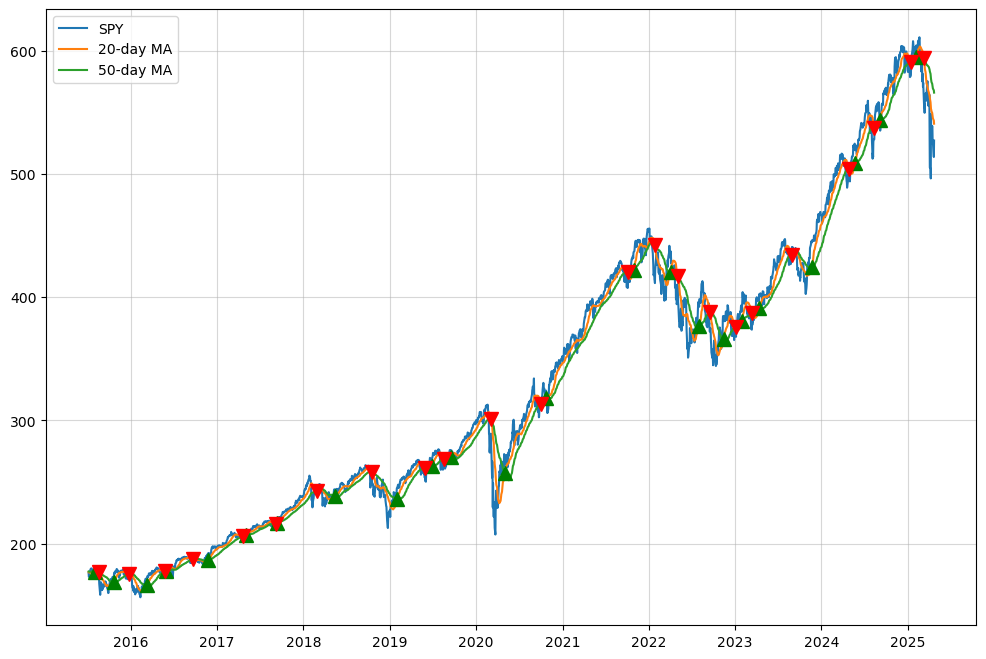

In [7]:
#parameters for grid size
plt.rcParams['figure.figsize'] = 12, 8
#create grid
plt.grid(True, alpha = .5)
#plot ticker closing prices and MAs, .iloc for integers
plt.plot(data.iloc[-model_days:]['Close'], label = f'{ticker.upper()}')
plt.plot(data.iloc[-model_days:][f'{MA1}-day MA'], label = f'{MA1}-day MA')
plt.plot(data.iloc[-model_days:][f'{MA2}-day MA'], label = f'{MA2}-day MA')
#plotting entry points, .loc for labels
plt.plot(data[-model_days:].loc[data.Entry == 2].index, data[-model_days:][f'{MA1}-day MA'][data.Entry == 2], '^', color = 'g', markersize = 10)
plt.plot(data[-model_days:].loc[data.Entry == -2].index, data[-model_days:][f'{MA2}-day MA'][data.Entry == -2], 'v', color = 'r', markersize = 10)
#plot legend
plt.legend(loc=2)

Creating Buy/Hold Comparison to MA Crossover Strategy

Buy/Hold Return: 199.79 %
Model Return: 36.49 %


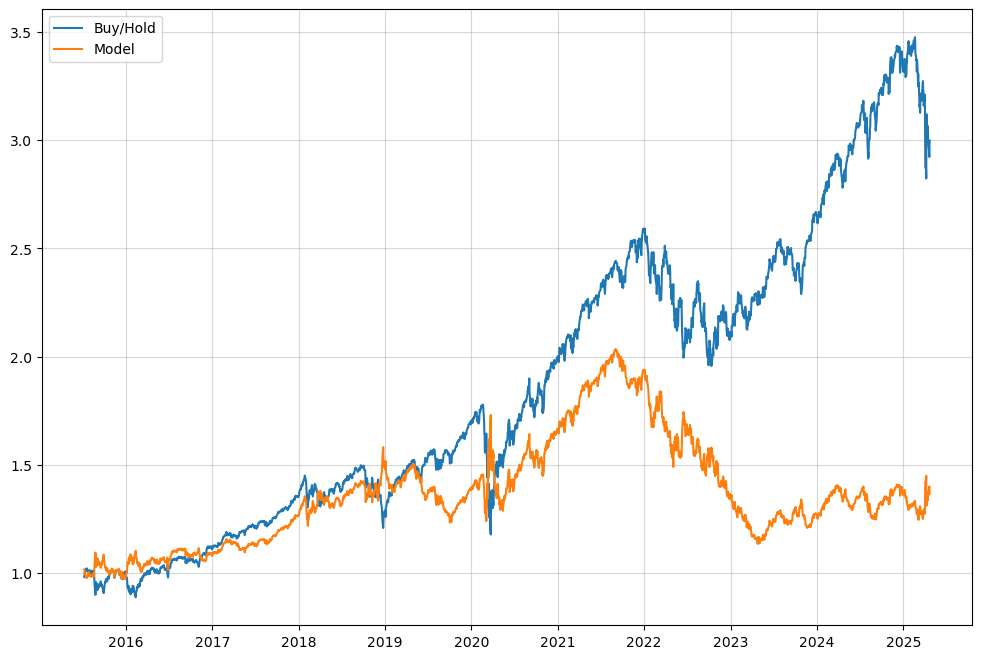

In [8]:
#buy/hold plot
plt.plot(np.exp(data['Return']).cumprod(), label='Buy/Hold')
#model plot
plt.plot(np.exp(data['Model Return']).cumprod(), label='Model')
plt.legend(loc=2)
plt.grid(True, alpha=.5)
#print returns
print("Buy/Hold Return:", round(((np.exp(data['Return']).cumprod().iloc[-1] -1) * 100), 2), "%")
print("Model Return:", round(((np.exp(data['Model Return']).cumprod().iloc[-1] -1) * 100), 2), "%")